# Comparing topics by gender

In previous notebooks, we have used speakers' genders to apply a gender label to each talk. The gender labels used are: male, female, and not one gender. We note that the list of speakers in the corpus of TED talks identify on the gender binary, at least in the public facing documents about them (which include their TED talk bios and third party websites and publicity). 


https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45

https://www.kaggle.com/code/adamschroeder/countvectorizer-tfidfvectorizer-predict-comments/notebook



## Summary




## Load Imports and Data

In [1]:
# IMPORTS

import numpy as np
import pandas as pd, re, csv, nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from nltk.corpus import stopwords
from scipy.spatial import distance

import matplotlib.pyplot as plt

In [2]:
# LOCAL FUNCTION --> Explained in 01-Terms.ipynb

parentheticals = [ "\(laughter\)", "\(applause\)", "\(music\)",  
                  "\(video\)", "\(laughs\)", "\(applause ends\)", 
                  "\(audio\)", "\(singing\)", "\(music ends\)", 
                  "\(cheers\)", "\(cheering\)", "\(recording\)", 
                  "\(beatboxing\)", "\(audience\)", "\(guitar strum\)", 
                  "\(clicks metronome\)", "\(sighs\)", "\(guitar\)", 
                  "\(marimba sounds\)", "\(drum sounds\)" ]

def remove_parentheticals(text):
    global parentheticals
    new_text = text
    for rgx_match in parentheticals:
        new_text = re.sub(rgx_match, ' ', new_text.lower(), 
                          flags=re.IGNORECASE)
    return new_text

In [3]:
# Load data

# Load binary gendered talks 
talks_male = pd.read_csv('talks_male.csv', index_col='Talk_ID')
talks_female = pd.read_csv('talks_female.csv', index_col='Talk_ID')

# No one gender ==> NOG
talks_nog = pd.read_csv('talks_nog.csv', index_col='Talk_ID')

In [4]:
# Concatenate the data
all_talks = pd.concat([talks_male,talks_female,talks_nog])


## Raw Frequencies
### Rewrite
The goal of this notebook is to establish how we are going to elicit our features, our words, from the collection of talks. Thus, the only column we are interested in is the one with the texts of the talks. While we recognize the utility of having the data in one file, we are looking to minimize individual file sizes, and also make it possible only to load the data we need for any particular task. For that reason, we have chosen to create a number of CSV files, using the ID number that TED assigns each talk as it publishes them to its website.

For this first experiment, we keep it simple by creating two lists, one of the talk IDs and one of the texts themselves: we will only be using the IDs later when we write the DTM to a CSV. This ID will allow us later to correlate the DTM with metadata associated with each talk: the speaker, her biography, the talk's popularity, etc. 

In [5]:
partitioned_texts = all_talks.text.tolist()

There are a number of ways to get term frequencies, but **SciKit-Learn**'s `CountVectorizer` offers a one-stop shop for generating a DTM from which we can examine words as well as generate BoW-products like topic models. This is made possible by the interoperability between `CountVectorizer` and the other vectorizers and models available in `sklearn`.



In our first experiment, we run `CountVectorizer` unadorned. The default options are: lowercase everything, get rid of all punctuation, make a word out of anything more than two characters long. The only thing that might not be welcome is the splitting of contractions. For now, we will leave things as they are. (Also, please note, no stopwords were used, so we have an unfiltered word list and no pre-processing of the texts is done.)

### CHECK THIS ASSERTION: 
Since `CountVectorizer` only counts when *fitting* and does not engage in any kind of normalization or centering, *transforming*, there is no need to break the two functionalities out in the code that follows.

In [6]:
# If you want to pass options, pass them here:
vectorizer = CountVectorizer(lowercase = True, 
                             min_df = 2,
                             max_df = 0.9)
# There are issues using "english" flag. But I wanted to see what 
#    would happen: 
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# Can put any list for `stop_words` flag. Options: 
# * 'english' - 39114
# * stopwords.words("english") - 39274 

# Experimenting with STRIP_ACCENTS:
# * ascii - adds 5 words to the list
# * unicode - removes 34 words

# Experimenting with MAX_DF
# * 0.7 -> 39055 (drops 25 words)
# * 0.5 -> 39018 (drops another 37)
# * 0.3 -> 38900 (drops 118 more)
# * 0.1 -> 38204 (drops nearly 700 more!)

# fit the model to the data 
# vecs = vectorizer.fit(partitioned_texts)
X = vectorizer.fit_transform(partitioned_texts)

# see how many features we have
X.shape

(982, 22331)

### Fix! 

39418 tokens is our raw, unfiltered, no pre-processing baseline. It includes, as we will see, a number of artifacts of the TED transcription process, including a variety of ways to spell out *ah*, the use of numerals for a host of things -- from dates to counts and everything in between, and some things which actually take places outside the talk itself, like audience laughter, which we here term *parentheticals*. (Accounting for all these artifacts requires a number of closer inspections, which take place in a separate notebook: [Term Artifacts](Terms-02).)

In [7]:
raw_df = pd.DataFrame(X.toarray(), 
                      columns = vectorizer.get_feature_names())
raw_df.shape

(982, 22331)

In [8]:
word_list = list(raw_df.columns)

len(word_list)

22331

In [9]:
word_list.index("aa")

410

In [10]:
word_list[410:421]

['aa',
 'aaa',
 'aaaah',
 'aah',
 'aaron',
 'ab',
 'aback',
 'abandon',
 'abandoned',
 'abandoning',
 'abbey']

In [11]:
word_list[414]

'aaron'

In [12]:
# First words start at index 789

414/len(word_list)

## About 2% of the way into the word list

0.018539250369441585

## Redo with Countvectorize

In [13]:
# See how many of the non-words each talk has (regardless of how many times each non-word appears.)
m_test = (raw_df.iloc[:714,:414]>0).sum(axis = 1)
f_test = (raw_df.iloc[714:(714+260),:414]>0).sum(axis = 1)

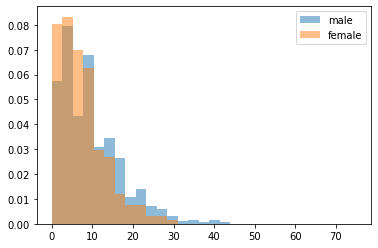

In [14]:
# https://stackoverflow.com/questions/6871201/plot-two-histograms-on-single-chart-with-matplotlib
bins = np.linspace(0,75,30)
plt.hist(m_test, bins, density=True,  alpha=0.5, label = "male")
plt.hist(f_test, bins, density=True, alpha=0.5, label = "female")
plt.legend(loc='upper right')
plt.show()

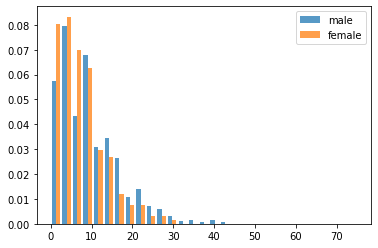

In [15]:
plt.hist([m_test,f_test], bins, density=True, alpha=0.75, label=['male','female'])
plt.legend(loc='upper right')
plt.show()

In [16]:
raw_series = raw_df.sum()

In [17]:
raw_series.head()

00          4
000      1187
000th       5
01          3
02          2
dtype: int64

Another caveat from the `01-Terms.ipynb` notebook: 
> The rest of the hand-examination turns up no other issues, so the basic vectorization built into `sklearn` appears to be satisfactory, with the only exception being its breaking of contractions at the apostrophe: e.g., *isn't* becomes *isn* and *'t*, with the latter being thrown away as too small -- which means that the indefinite article *a(n)* is also not present in the frequencies, but the definite article *the* remains. 

## Remove the non-words:

In [18]:
trunc_df = raw_df.iloc[:,414:]
trunc_df.shape


(982, 21917)

In [19]:
raw_df.shape[1] - trunc_df.shape[1]

414

## Topics (NMF) - all talks

In [20]:
k = 100
model = NMF( init="nndsvd", n_components= k, max_iter = 500 ) 
# apply the model and extract the two factor matrices
talk_topic = model.fit_transform(trunc_df)
topic_word = model.components_

/Users/kkinnaird/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [21]:
talk_topic.shape, topic_word.shape


((982, 100), (100, 21917))

In [22]:
talk_topic

array([[1.52509531e-01, 1.09964361e-01, 9.42339568e-02, ...,
        0.00000000e+00, 5.02638901e-01, 0.00000000e+00],
       [6.28930745e-02, 2.61180051e-01, 0.00000000e+00, ...,
        1.73877460e-01, 5.87262824e-01, 1.37600850e-01],
       [1.14617058e-01, 7.61033811e-01, 3.85693630e-01, ...,
        0.00000000e+00, 2.76109955e-02, 6.90753285e-04],
       ...,
       [5.71172760e-02, 1.83926893e+00, 0.00000000e+00, ...,
        0.00000000e+00, 2.80674733e-01, 0.00000000e+00],
       [0.00000000e+00, 1.04386343e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.77541272e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 2.55303573e-02]])

In [23]:
topic_word

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.03142056, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00018657]])

In [24]:
# Create a topic-word matrix that places a 1 where there are 
one_mat = np.ones(topic_word.shape)

topic_word_bin = (topic_word>0)*one_mat

# Count the number of words in each topic
np.sort(topic_word_bin.sum(axis = 1))

array([ 462.,  784.,  867.,  909.,  954., 1039., 1226., 1383., 1392.,
       1419., 1443., 1521., 1550., 1696., 1706., 1718., 1834., 1858.,
       1886., 1935., 1946., 1955., 2004., 2022., 2078., 2131., 2149.,
       2216., 2282., 2296., 2411., 2429., 2456., 2476., 2491., 2646.,
       2657., 2697., 2856., 2934., 2940., 2945., 2977., 3032., 3064.,
       3123., 3126., 3134., 3268., 3364., 3371., 3381., 3383., 3384.,
       3390., 3395., 3437., 3444., 3485., 3508., 3518., 3531., 3538.,
       3598., 3600., 3616., 3626., 3656., 3665., 3728., 3737., 3768.,
       3809., 3813., 3833., 3847., 3854., 3861., 3870., 3874., 3896.,
       3933., 3936., 3957., 3957., 3959., 4033., 4042., 4120., 4132.,
       4134., 4142., 4165., 4296., 4318., 4676., 4774., 4778., 4868.,
       5097.])

In [25]:
print("Average number of words per column is:", topic_word_bin.sum(axis = 1).mean(), 
      "with a standard deviation of:", round(topic_word_bin.sum(axis = 1).std(),2))

Average number of words per column is: 2994.2 with a standard deviation of: 1062.37


In [26]:
topic_word_bin.shape[1]/k


219.17

In [27]:
topics_per_word = topic_word_bin.sum(axis = 0)

In [28]:
max(topics_per_word)

72.0

In [29]:
min(topics_per_word)

1.0

In [30]:
np.mean(topics_per_word)

13.661541269334307

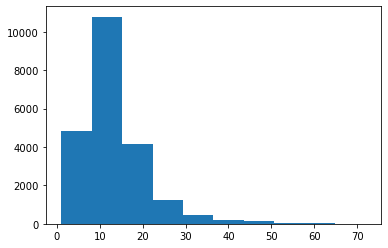

In [31]:
plt.hist(topics_per_word)
plt.show()

In [32]:
## Not sure this makes sense in tf-idf land

(topic_word).sum(axis = 1)

array([ 134.46521742,   84.37904659,  114.91281187,  304.25093469,
        206.3725099 ,   56.26289623,  115.82414047,  345.64313498,
        204.64015063,  665.27580981,  124.6899379 ,  133.27249963,
        142.68568156,  732.69760887,  337.12089636,  676.84984655,
        212.41275748,  112.5524363 ,  138.05992692,  371.18695941,
         86.9693398 ,  404.54707849, 1137.39812479,  769.83410987,
        482.11747747,  134.582128  ,  485.0115792 ,  207.80622792,
        164.38003988,  309.18285209,   69.18171967,  538.55916426,
        587.02848086,  363.3955802 ,  704.29446596,  570.84914713,
        314.91506394,  214.01664212,  289.82180937,  301.10804814,
        305.81390313,  158.2669683 ,  312.68642267,  376.61834533,
        319.95603941,  161.48247536,  297.03857301,  293.16211436,
        269.13517448,  116.52679681,   82.09016107,   89.57172633,
        421.48464249,  158.20573145,  279.80116062,  204.6371041 ,
         92.38168187,  131.64910268,  205.57469769,  270.78193

## Topics (NMF) - male talks -- 100 topics

In [33]:
# Get just the male rows of the full talk-word frequency matrix
male_tw = trunc_df.iloc[:714,:]

In [34]:
# Run NMF with 100 topics
k = 100
model = NMF( init="nndsvd", n_components= k, max_iter = 500 ) 
# apply the model and extract the two factor matrices
m_talk_topic = model.fit_transform(male_tw)
m_topic_word = model.components_

In [35]:
## Compute some statistics on the output
# Create a topic-word matrix that places a 1 where there are 
m_one_mat = np.ones(m_topic_word.shape)

m_topic_word_bin = (m_topic_word>0)*m_one_mat

# Count the number of words in each topic
np.sort(m_topic_word_bin.sum(axis = 1))

array([ 469., 1010., 1088., 1166., 1643., 1715., 1722., 1771., 1809.,
       1888., 1964., 1990., 2022., 2042., 2107., 2128., 2204., 2248.,
       2302., 2308., 2311., 2322., 2442., 2453., 2536., 2543., 2559.,
       2619., 2745., 2747., 2856., 2878., 2883., 2890., 2971., 3022.,
       3050., 3058., 3076., 3106., 3106., 3113., 3133., 3150., 3181.,
       3184., 3227., 3231., 3236., 3253., 3259., 3276., 3276., 3277.,
       3291., 3312., 3341., 3343., 3345., 3351., 3379., 3382., 3408.,
       3423., 3434., 3453., 3457., 3476., 3497., 3510., 3511., 3528.,
       3541., 3550., 3574., 3579., 3610., 3629., 3629., 3649., 3660.,
       3697., 3724., 3760., 3848., 3865., 3895., 3900., 3912., 3914.,
       3918., 3921., 3968., 4003., 4192., 4217., 4220., 4313., 4711.,
       4921.])

In [36]:
print("Average number of words per column is:", m_topic_word_bin.sum(axis = 1).mean(), 
      "with a standard deviation of:", round(m_topic_word_bin.sum(axis = 1).std(),2))

Average number of words per column is: 3063.26 with a standard deviation of: 814.19


In [37]:
## Not sure this makes sense in tf-idf land

(m_topic_word).sum(axis = 1)

array([735.15110803,  83.46479736, 398.1945258 ,  62.02918615,
       228.00335574, 138.98409874, 175.2659196 , 975.7891906 ,
       146.30603674, 718.88669861, 445.48269206, 219.25001349,
        96.8525437 , 773.58167383, 444.13681226, 163.91001329,
       312.79828472, 518.7776496 , 146.71445158, 115.66325212,
       238.90121792, 522.89570326, 758.39001284, 718.16002532,
       735.07526149, 243.48317783, 276.19438348, 179.4539278 ,
       454.36740395, 764.89534291, 281.36746704, 384.71630131,
       200.08249956, 399.71517482, 309.26411928, 368.97865034,
       312.90235678, 270.89449171, 345.57751165, 182.72117202,
       191.33272693, 216.34651661, 286.40313701, 390.57908373,
       264.93527232, 287.38000264, 293.79404161, 291.32419992,
       138.14883703, 201.89759228, 315.05440865, 223.26134283,
       229.15076876, 110.78465967, 290.8755022 , 353.87200529,
        61.37451557, 106.2358611 , 254.458691  , 183.31009517,
       300.04065941, 194.7089691 , 185.43600601, 232.54

### Adjusting our number of topics


In [38]:
k_adj = int(round(100*talks_male.shape[0]/all_talks.shape[0],0))

Given that approximately 73 percent of the talks are male, we now try lowering the number of topics to that number

In [39]:
k_adj

73

In [40]:
# Run NMF with adjusted K topics
model_adj = NMF( init="nndsvd", n_components= k_adj, max_iter = 500 ) 
# apply the model and extract the two factor matrices
m_talk_topic_adj = model_adj.fit_transform(male_tw)
m_topic_word_adj = model_adj.components_

/Users/kkinnaird/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [41]:
## Compute some statistics on the output
# Create a topic-word matrix that places a 1 where there are 
m_one_mat_adj = np.ones(m_topic_word_adj.shape)

m_topic_word_adj_bin = (m_topic_word_adj>0)*m_one_mat_adj

# Count the number of words in each topic
np.sort(m_topic_word_adj_bin.sum(axis = 1))

array([ 928., 1266., 1879., 2039., 2169., 2236., 2273., 2390., 2480.,
       2635., 2653., 2689., 2735., 2784., 2796., 2826., 2829., 2883.,
       2907., 3000., 3025., 3033., 3048., 3194., 3197., 3199., 3263.,
       3283., 3303., 3376., 3397., 3401., 3415., 3420., 3436., 3485.,
       3493., 3497., 3535., 3585., 3609., 3610., 3641., 3662., 3704.,
       3752., 3774., 3801., 3811., 3818., 3835., 3845., 3846., 3906.,
       3916., 3917., 3990., 4016., 4057., 4067., 4080., 4083., 4168.,
       4237., 4256., 4266., 4302., 4489., 4509., 4554., 4966., 4985.,
       5057.])

In [42]:
print("Average number of words per column is:", m_topic_word_adj_bin.sum(axis = 1).mean(), 
      "with a standard deviation of:", round(m_topic_word_adj_bin.sum(axis = 1).std(),2))

Average number of words per column is: 3417.958904109589 with a standard deviation of: 790.77


## Topics (NMF) - female talks -- 100 topics

In [43]:
# Get just the female rows of the full talk-word frequency matrix
female_tw = trunc_df.iloc[714:(714+260),:]

In [44]:
# Run NMF with 100 topics
k = 100
model = NMF( init="nndsvd", n_components= k, max_iter = 500 ) 
# apply the model and extract the two factor matrices
f_talk_topic = model.fit_transform(female_tw)
f_topic_word = model.components_

In [45]:
## Compute some statistics on the output
# Create a topic-word matrix that places a 1 where there are 
f_one_mat = np.ones(f_topic_word.shape)

f_topic_word_bin = (f_topic_word>0)*f_one_mat

# Count the number of words in each topic
np.sort(f_topic_word_bin.sum(axis = 1))

array([1871., 2041., 2091., 2121., 2259., 2266., 2309., 2310., 2348.,
       2354., 2359., 2395., 2453., 2453., 2475., 2517., 2520., 2525.,
       2545., 2557., 2576., 2588., 2595., 2600., 2601., 2612., 2615.,
       2617., 2628., 2643., 2662., 2662., 2665., 2683., 2729., 2729.,
       2729., 2730., 2731., 2761., 2765., 2787., 2792., 2833., 2838.,
       2843., 2866., 2872., 2878., 2896., 2902., 2909., 2912., 2922.,
       2924., 2928., 2949., 2953., 2989., 2992., 3012., 3025., 3029.,
       3030., 3030., 3087., 3111., 3118., 3128., 3129., 3136., 3139.,
       3144., 3145., 3154., 3155., 3156., 3174., 3186., 3222., 3227.,
       3243., 3264., 3267., 3273., 3291., 3320., 3330., 3353., 3377.,
       3435., 3452., 3458., 3490., 3541., 3545., 3824., 3864., 3915.,
       4069.])

In [46]:
print("Average number of words per column is:", f_topic_word_bin.sum(axis = 1).mean(), 
      "with a standard deviation of:", round(f_topic_word_bin.sum(axis = 1).std(),2))

Average number of words per column is: 2895.23 with a standard deviation of: 413.82


In [47]:
## Not sure this makes sense in tf-idf land


(f_topic_word).sum(axis = 1)

array([1694.58952446,  266.01104441,  180.76641031,  241.0362478 ,
        924.29381922,  124.95649121,  338.57971695,  269.26393497,
         90.75874148,  277.45877779, 1196.92644251,  712.79025495,
        453.04521038,  626.59897349,  785.65780675,  458.8832884 ,
        238.63168083,  259.19851458,  692.3193293 ,  655.10379182,
        845.74650362,  659.50080777,  219.46259791,  373.12144022,
        318.41398179,  267.54498055,  223.85857123,  382.75419581,
        336.09737172,  299.52216764,  120.70077368,  410.3811404 ,
        208.50813361,  188.94073328,  295.98330204,  835.90828725,
        664.76273246,  160.18316154,  236.45545572,  556.9746579 ,
        295.6944839 ,  660.77295687,  197.70071121,  240.37130497,
        168.50369219,  280.09949446,  238.9395526 ,  314.39772067,
        162.24507114,  302.59441219,  333.94903595,  451.2282702 ,
        381.61332636,  232.49310928,  232.54966324,  202.41690209,
        169.82232395,  158.18213698,  210.49291326,  287.94628

### Adjusting our number of topics


In [48]:
k_adj = int(round(100*talks_female.shape[0]/all_talks.shape[0],0))

In [49]:
k_adj

26

Given that approximately 26 percent of the talks are female, we now try lowering the number of topics to that number

In [50]:
# Run NMF with adjusted K topics
model_adj = NMF( init="nndsvd", n_components= k_adj, max_iter = 500 ) 
# apply the model and extract the two factor matrices
f_talk_topic_adj = model_adj.fit_transform(female_tw)
f_topic_word_adj = model_adj.components_

In [51]:
## Compute some statistics on the output
# Create a topic-word matrix that places a 1 where there are 
f_one_mat_adj = np.ones(f_topic_word_adj.shape)

f_topic_word_adj_bin = (f_topic_word_adj>0)*f_one_mat_adj

# Count the number of words in each topic
np.sort(f_topic_word_adj_bin.sum(axis = 1))

array([3373., 3494., 3619., 3728., 3870., 4121., 4263., 4268., 4384.,
       4396., 4538., 4547., 4575., 4679., 4683., 4877., 4963., 5066.,
       5157., 5195., 5709., 5747., 6045., 6146., 6264., 6610.])

In [52]:
print("Average number of words per column is:", f_topic_word_adj_bin.sum(axis = 1).mean(), 
      "with a standard deviation of:", round(f_topic_word_adj_bin.sum(axis = 1).std(),2))

Average number of words per column is: 4781.423076923077 with a standard deviation of: 868.53


# Comparing the topics for each run

We will compare the following pairs: 
 * (male 100, male 72)
 * (female 100, female 26)
 * (all, male 100)
 * (all, female 100)
 * (male 100, female 100)
 * (all, male 72)
 * (all, female 26)
 * (male 72, female 26)
 
For all comparisons, we will use `cdist` and the cosine similarity measure. That is if $D$ is the cosine distance, then the cosine similiarity matrix would be $1-D$

In [53]:
# Male to Male comparisons

D = distance.cdist(m_topic_word, m_topic_word_adj, "cosine")
m2m_sim = np.ones(D.shape) - D

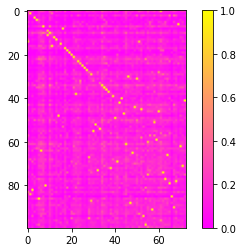

In [54]:
plt.imshow(m2m_sim, cmap = "spring")
plt.clim(0,1)
plt.colorbar()

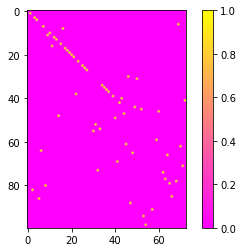

In [55]:
thresh_m2m = m2m_sim > 0.9
plt.imshow(m2m_sim*thresh_m2m, cmap = "spring")
plt.clim(0,1)
plt.colorbar()

In [56]:
no_match_col = np.sum(thresh_m2m, axis = 0)

In [57]:
sum(no_match_col)

62

In [58]:
no_match_row = np.sum(thresh_m2m, axis = 1)

In [59]:
sum(no_match_row)

62

In [60]:
highest_by_row = np.argmax(m2m_sim,axis = 1)

In [61]:
highest_by_row

array([61,  1, 65,  3,  4, 56, 69,  7, 16,  9, 10,  9, 12, 13,  0, 15, 11,
       17, 18, 19, 20, 21, 54, 23, 24, 25, 26, 27, 60, 29, 46, 50, 24, 33,
       34, 35, 36, 37, 22, 39, 43, 72, 42, 67, 49, 52, 60, 44, 14, 40, 50,
       58, 31, 16, 33, 30, 61, 58, 52, 59, 55, 45, 70, 50,  6, 48, 64, 28,
       39, 41, 49, 71, 38, 32, 62, 55, 34, 63, 68, 65,  8, 54,  2,  0,  1,
       66,  5, 29, 47, 45, 67, 57, 28, 51, 53, 28, 61, 54, 54, 55])

In [62]:
highest_by_col = np.argmax(m2m_sim,axis = 0)

In [63]:
highest_by_col

array([14,  1, 82,  3,  4, 86, 64,  7, 80, 11, 10, 16, 12, 13, 48, 15,  8,
       17, 18, 19, 20, 21, 38, 23, 24, 25, 26, 27, 67, 29, 55, 52, 73, 54,
       34, 35, 36, 37, 72, 39, 49, 69, 42, 40, 47, 61, 30, 88, 65, 44, 31,
       14, 45, 94, 98, 60, 57, 91, 51, 59, 46,  0, 74, 77, 66, 79, 85, 90,
       78,  6, 62, 71, 41])

In [64]:
highest_by_row[highest_by_col]


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        0, 52, 53, 54, 55, 58, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72])

In [65]:
max_by_row = np.max(m2m_sim,axis = 1)

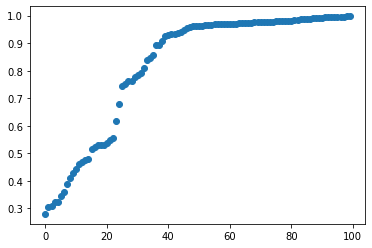

In [66]:
plt.scatter(range(100),np.sort(max_by_row))

In [67]:
# female to female comparisons

D = distance.cdist(f_topic_word, f_topic_word_adj, "cosine")
f2f_sim = np.ones(D.shape) - D

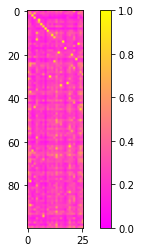

In [68]:
plt.imshow(f2f_sim, cmap = "spring")
plt.clim(0,1)
plt.colorbar()

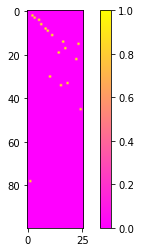

In [69]:
thresh_f2f = f2f_sim > 0.9
plt.imshow(f2f_sim*thresh_f2f, cmap = "spring")
plt.clim(0,1)
plt.colorbar()

In [70]:
max_by_row = np.max(f2f_sim,axis = 1)

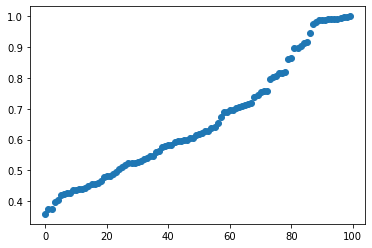

In [71]:
plt.scatter(range(100),np.sort(max_by_row))

In [72]:
# All to Male100 comparisons

D = distance.cdist(topic_word, m_topic_word, "cosine")
a2m100_sim = np.ones(D.shape) - D

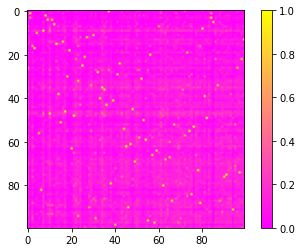

In [73]:
plt.imshow(a2m100_sim, cmap = "spring")
plt.clim(0,1)
plt.colorbar()

In [74]:
# All to female100 comparisons

D = distance.cdist(topic_word, f_topic_word, "cosine")
a2f100_sim = np.ones(D.shape) - D

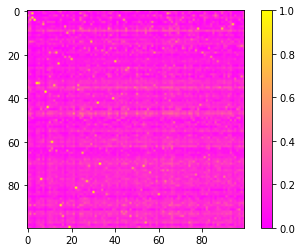

In [75]:
plt.imshow(a2f100_sim, cmap = "spring")
plt.clim(0,1)
plt.colorbar()

In [76]:
# Male100 to female100 comparisons

D = distance.cdist(m_topic_word, f_topic_word, "cosine")
m2f100_sim = np.ones(D.shape) - D

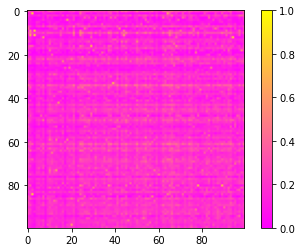

In [77]:
plt.imshow(m2f100_sim, cmap = "spring")
plt.clim(0,1)
plt.colorbar()

In [78]:
# All to Male Adj comparisons

D = distance.cdist(topic_word, m_topic_word_adj, "cosine")
a2m_adj_sim = np.ones(D.shape) - D

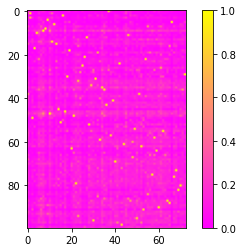

In [79]:
plt.imshow(a2m_adj_sim, cmap = "spring")
plt.clim(0,1)
plt.colorbar()

In [80]:
# All to Female Adj comparisons

D = distance.cdist(topic_word, f_topic_word_adj, "cosine")
a2f_adj_sim = np.ones(D.shape) - D

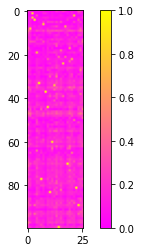

In [81]:
plt.imshow(a2f_adj_sim, cmap = "spring")
plt.clim(0,1)
plt.colorbar()

In [82]:
# Male adj to female adj comparisons

D = distance.cdist(m_topic_word_adj, f_topic_word_adj, "cosine")
m2f_adj_sim = np.ones(D.shape) - D

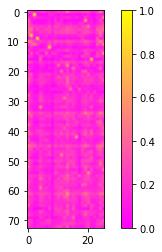

In [83]:
plt.imshow(m2f_adj_sim, cmap = "spring")
plt.clim(0,1)
plt.colorbar()